# **Итоговая работа по курсу Machine Learning Junior**

# **Сборка датасета**

In [ ]:
import os
import pandas as pd
import tqdm


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, start_step: int = 0, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(start_step, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        
   #здесь должен быть препроцессинг данных
        
        # числовые признаки
        preprocessed_frame = transactions_frame.groupby('id')[['rn']].max()
        # суммы числовых признаков
        preprocessed_frame['count_is_zero_loans5'] = transactions_frame.groupby('id')['is_zero_loans5'].sum()
        preprocessed_frame['count_is_zero_loans530'] = transactions_frame.groupby('id')['is_zero_loans530'].sum()
        preprocessed_frame['count_is_zero_loans3060'] = transactions_frame.groupby('id')['is_zero_loans3060'].sum()
        preprocessed_frame['count_is_zero_loans6090'] = transactions_frame.groupby('id')['is_zero_loans6090'].sum()
        preprocessed_frame['count_is_zero_loans90'] = transactions_frame.groupby('id')['is_zero_loans90'].sum()
        preprocessed_frame['count_is_zero_util'] = transactions_frame.groupby('id')['is_zero_util'].sum()
        preprocessed_frame['count_is_zero_over2limit'] = transactions_frame.groupby('id')['is_zero_over2limit'].sum()
        preprocessed_frame['count_is_zero_maxover2limit'] = transactions_frame.groupby('id')['is_zero_maxover2limit'].sum()
        preprocessed_frame['count_pclose_flag'] = transactions_frame.groupby('id')['pclose_flag'].sum()
        preprocessed_frame['count_fclose_flag'] = transactions_frame.groupby('id')['fclose_flag'].sum()

        # числовые признаки по последним кредитам у заемщиков
        preprocessed_frame['last_is_zero_loans5'] = transactions_frame.groupby('id')['is_zero_loans5'].last()
        preprocessed_frame['last_is_zero_loans530'] = transactions_frame.groupby('id')['is_zero_loans530'].last()
        preprocessed_frame['last_is_zero_loans3060'] = transactions_frame.groupby('id')['is_zero_loans3060'].last()
        preprocessed_frame['last_is_zero_loans6090'] = transactions_frame.groupby('id')['is_zero_loans6090'].last()
        preprocessed_frame['last_is_zero_loans90'] = transactions_frame.groupby('id')['is_zero_loans90'].last()
        preprocessed_frame['last_is_zero_util'] = transactions_frame.groupby('id')['is_zero_util'].last()
        preprocessed_frame['last_is_zero_over2limit'] = transactions_frame.groupby('id')['is_zero_over2limit'].last()
        preprocessed_frame['last_is_zero_maxover2limit'] = transactions_frame.groupby('id')['is_zero_maxover2limit'].last()
        preprocessed_frame['last_pclose_flag'] = transactions_frame.groupby('id')['pclose_flag'].last()
        preprocessed_frame['last_fclose_flag'] = transactions_frame.groupby('id')['fclose_flag'].last()        

        # # закодированные признаки самое популярное
        preprocessed_frame['holder_type'] = transactions_frame.groupby('id')['enc_loans_account_holder_type'].apply(lambda x: x.mode()[0])
        preprocessed_frame['credit_status'] = transactions_frame.groupby('id')['enc_loans_credit_status'].apply(lambda x: x.mode())
        # preprocessed_frame['account_cur'] = transactions_frame.groupby('id')['enc_loans_account_cur'].apply(lambda x: x.mode())
        preprocessed_frame['credit_type'] = transactions_frame.groupby('id')['enc_loans_credit_type'].apply(lambda x: x.mode())

        for i in range(25):
            preprocessed_frame[f'paym_status_{i}'] = transactions_frame.groupby('id')[f'enc_paym_{i}'].apply(lambda x: x.mode())

        # закодированные признаки последнее
        preprocessed_frame['last_holder_type'] = transactions_frame.groupby('id')['enc_loans_account_holder_type'].last()
        preprocessed_frame['last_credit_status'] = transactions_frame.groupby('id')['enc_loans_credit_status'].last()
        # preprocessed_frame['last_account_cur'] = transactions_frame.groupby('id')['enc_loans_account_cur'].last()
        preprocessed_frame['last_credit_type'] = transactions_frame.groupby('id')['enc_loans_credit_type'].last()

        for i in range(25):
            preprocessed_frame[f'last_paym_status_{i}'] = transactions_frame.groupby('id')[f'enc_paym_{i}'].last()
        
        # бинарные признаки
        preprocessed_frame['since_opened'] = transactions_frame.groupby('id')['pre_since_opened'].last()
        preprocessed_frame['since_confirmed'] = transactions_frame.groupby('id')['pre_since_confirmed'].last()
        preprocessed_frame['pterm'] = transactions_frame.groupby('id')['pre_pterm'].last()
        preprocessed_frame['fterm'] = transactions_frame.groupby('id')['pre_fterm'].last()
        preprocessed_frame['till_pclose'] = transactions_frame.groupby('id')['pre_till_pclose'].last()
        preprocessed_frame['till_fclose'] = transactions_frame.groupby('id')['pre_till_fclose'].last()
        
        preprocessed_frame['credit_limit'] = transactions_frame.groupby('id')['pre_loans_credit_limit'].last()
        preprocessed_frame['next_pay_summ'] = transactions_frame.groupby('id')['pre_loans_next_pay_summ'].last()
        preprocessed_frame['loans_outstanding'] = transactions_frame.groupby('id')['pre_loans_outstanding'].last()
        preprocessed_frame['total_overdue'] = transactions_frame.groupby('id')['pre_loans_total_overdue'].last()
        preprocessed_frame['max_overdue_sum'] = transactions_frame.groupby('id')['pre_loans_max_overdue_sum'].last()
        preprocessed_frame['credit_cost_rate'] = transactions_frame.groupby('id')['pre_loans_credit_cost_rate'].last()
        preprocessed_frame['pre_loans5'] = transactions_frame.groupby('id')['pre_loans5'].last()
        preprocessed_frame['pre_loans530'] = transactions_frame.groupby('id')['pre_loans530'].last()
        preprocessed_frame['pre_loans3060'] = transactions_frame.groupby('id')['pre_loans3060'].last()
        preprocessed_frame['pre_loans6090'] = transactions_frame.groupby('id')['pre_loans6090'].last()
        preprocessed_frame['pre_loans90'] = transactions_frame.groupby('id')['pre_loans90'].last()
        preprocessed_frame['pre_util'] = transactions_frame.groupby('id')['pre_util'].last()
        preprocessed_frame['pre_over2limit'] = transactions_frame.groupby('id')['pre_over2limit'].last()
        preprocessed_frame['pre_maxover2limit'] = transactions_frame.groupby('id')['pre_maxover2limit'].last()


   #записываем подготовленные данные в файл
        # if save_to_path:
        #     block_as_str = str(step)
        #     if len(block_as_str) == 1:
        #         block_as_str = '00' + block_as_str
        #     else:
        #         block_as_str = '0' + block_as_str
        #     transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(preprocessed_frame)
    return pd.concat(preprocessed_frames)

## **Описание датасета**

Выгружаем количество кредитов у одного заемщика. Количество кредитов необходимо для установления закономерности количества кредитов и возможного дефолта заемщика. Кроме этого, предполагаю использовать данную фичу для генерации новых фичей. Кроме этого, при моделировании будем использовать id клиента, так как из условия задачи номер клиента отражает информацию о времени их обращения за кредитом, что также влияет на актуальность информации и обстоятельств возникновения дефолта.

In [1]:
# preprocessed_frame = transactions_frame.groupby('id')[['rn']].max()

Посчитаем количество признаков, которые описывают наличие либо отсутствие флага по конкретному событию либо бакету. Необходимо для дальнейшей генерации фичей, связанных с расчетом доли количество событий бакетов от коичества кредитов у заемщика.

In [ ]:
# preprocessed_frame['count_is_zero_loans5'] = transactions_frame.groupby('id')['is_zero_loans5'].sum()
# preprocessed_frame['count_is_zero_loans530'] = transactions_frame.groupby('id')['is_zero_loans530'].sum()
# preprocessed_frame['count_is_zero_loans3060'] = transactions_frame.groupby('id')['is_zero_loans3060'].sum()
# preprocessed_frame['count_is_zero_loans6090'] = transactions_frame.groupby('id')['is_zero_loans6090'].sum()
# preprocessed_frame['count_is_zero_loans90'] = transactions_frame.groupby('id')['is_zero_loans90'].sum()
# preprocessed_frame['count_is_zero_util'] = transactions_frame.groupby('id')['is_zero_util'].sum()
# preprocessed_frame['count_is_zero_over2limit'] = transactions_frame.groupby('id')['is_zero_over2limit'].sum()
# preprocessed_frame['count_is_zero_maxover2limit'] = transactions_frame.groupby('id')['is_zero_maxover2limit'].sum()
# preprocessed_frame['count_pclose_flag'] = transactions_frame.groupby('id')['pclose_flag'].sum()
# preprocessed_frame['count_fclose_flag'] = transactions_frame.groupby('id')['fclose_flag'].sum()

Отдельно выгрузим признаки по конкретному событию либо бакету по последнему кредиту у заемщика. По информации из описании фичей, последние объекты у заемщиков соответствуют времени обращения за кредитом. Более "свежая" информация в большей мере отражает ситуацию у заемщика, которая может привести к дефолту. С учетом того, что другой временной отсечки в базе данных нет, чтоб совершить отбор информации по кредитам за некоторое время, например за 2 года, выгрузим в наш датасет все имеющиеся фичи по последнему кредиту заемщика.

In [ ]:
# preprocessed_frame['last_is_zero_loans5'] = transactions_frame.groupby('id')['is_zero_loans5'].last()
# preprocessed_frame['last_is_zero_loans530'] = transactions_frame.groupby('id')['is_zero_loans530'].last()
# preprocessed_frame['last_is_zero_loans3060'] = transactions_frame.groupby('id')['is_zero_loans3060'].last()
# preprocessed_frame['last_is_zero_loans6090'] = transactions_frame.groupby('id')['is_zero_loans6090'].last()
# preprocessed_frame['last_is_zero_loans90'] = transactions_frame.groupby('id')['is_zero_loans90'].last()
# preprocessed_frame['last_is_zero_util'] = transactions_frame.groupby('id')['is_zero_util'].last()
# preprocessed_frame['last_is_zero_over2limit'] = transactions_frame.groupby('id')['is_zero_over2limit'].last()
# preprocessed_frame['last_is_zero_maxover2limit'] = transactions_frame.groupby('id')['is_zero_maxover2limit'].last()
# preprocessed_frame['last_pclose_flag'] = transactions_frame.groupby('id')['pclose_flag'].last()
# preprocessed_frame['last_fclose_flag'] = transactions_frame.groupby('id')['fclose_flag'].last()

# preprocessed_frame['last_holder_type'] = transactions_frame.groupby('id')['enc_loans_account_holder_type'].last()
# preprocessed_frame['last_credit_status'] = transactions_frame.groupby('id')['enc_loans_credit_status'].last()
# preprocessed_frame['last_account_cur'] = transactions_frame.groupby('id')['enc_loans_account_cur'].last()
# preprocessed_frame['last_credit_type'] = transactions_frame.groupby('id')['enc_loans_credit_type'].last()

# for i in range(25):
#     preprocessed_frame[f'last_paym_status_{i}'] = transactions_frame.groupby('id')[f'enc_paym_{i}'].last()

# preprocessed_frame['since_opened'] = transactions_frame.groupby('id')['pre_since_opened'].last()
# preprocessed_frame['since_confirmed'] = transactions_frame.groupby('id')['pre_since_confirmed'].last()
# preprocessed_frame['pterm'] = transactions_frame.groupby('id')['pre_pterm'].last()
# preprocessed_frame['fterm'] = transactions_frame.groupby('id')['pre_fterm'].last()
# preprocessed_frame['till_pclose'] = transactions_frame.groupby('id')['pre_till_pclose'].last()
# preprocessed_frame['till_fclose'] = transactions_frame.groupby('id')['pre_till_fclose'].last()

# preprocessed_frame['credit_limit'] = transactions_frame.groupby('id')['pre_loans_credit_limit'].last()
# preprocessed_frame['next_pay_summ'] = transactions_frame.groupby('id')['pre_loans_next_pay_summ'].last()
# preprocessed_frame['loans_outstanding'] = transactions_frame.groupby('id')['pre_loans_outstanding'].last()
# preprocessed_frame['total_overdue'] = transactions_frame.groupby('id')['pre_loans_total_overdue'].last()
# preprocessed_frame['max_overdue_sum'] = transactions_frame.groupby('id')['pre_loans_max_overdue_sum'].last()
# preprocessed_frame['credit_cost_rate'] = transactions_frame.groupby('id')['pre_loans_credit_cost_rate'].last()
# preprocessed_frame['pre_loans5'] = transactions_frame.groupby('id')['pre_loans5'].last()
# preprocessed_frame['pre_loans530'] = transactions_frame.groupby('id')['pre_loans530'].last()
# preprocessed_frame['pre_loans3060'] = transactions_frame.groupby('id')['pre_loans3060'].last()
# preprocessed_frame['pre_loans6090'] = transactions_frame.groupby('id')['pre_loans6090'].last()
# preprocessed_frame['pre_loans90'] = transactions_frame.groupby('id')['pre_loans90'].last()
# preprocessed_frame['pre_util'] = transactions_frame.groupby('id')['pre_util'].last()
# preprocessed_frame['pre_over2limit'] = transactions_frame.groupby('id')['pre_over2limit'].last()
# preprocessed_frame['pre_maxover2limit'] = transactions_frame.groupby('id')['pre_maxover2limit'].last()

Отдельно в датасет выгрузим информацию по самым популярным закодированным признакам для установления зависимостей возникновения дефолта от данных признаков.

In [ ]:
# preprocessed_frame['holder_type'] = transactions_frame.groupby('id')['enc_loans_account_holder_type'].apply(lambda x: x.mode()[0])
# preprocessed_frame['credit_status'] = transactions_frame.groupby('id')['enc_loans_credit_status'].apply(lambda x: x.mode())
# preprocessed_frame['account_cur'] = transactions_frame.groupby('id')['enc_loans_account_cur'].apply(lambda x: x.mode())
# preprocessed_frame['credit_type'] = transactions_frame.groupby('id')['enc_loans_credit_type'].apply(lambda x: x.mode())

# for i in range(25):
#     preprocessed_frame[f'paym_status_{i}'] = transactions_frame.groupby('id')[f'enc_paym_{i}'].apply(lambda x: x.mode())

## **Сохранение датасета**

Отдельно обработаем каждую партицию и выгрузим наши фичи в отдельный файл.

In [ ]:
for i in range(12):
    df = prepare_transactions_dataset('data', 1, i, i+1, 'data')
    df.to_csv(f'data/df_{i}.csv')
    print(f'Сохранение в датафрейм {i} партиции')

Соберем все полученные файлы в один датасет.

In [ ]:
df_add = []
for i in range(12):
    df_part = pd.read_csv(f'data/df_{i}.csv', index_col='id')
    df_add.append(df_part)

df_add = pd.concat(df_add).sort_index()
df_add.head()

In [ ]:
df_add.shape

Загрузим файл с целевой переменной.

In [ ]:
df_target = pd.read_csv('data/train_target.csv', index_col='id')
df_target.head()

Соединим собранный датасет с целевой переменной.

In [ ]:
df = pd.merge(df_add, df_target, how='left', on='id')
df.to_csv('data/df_full.csv')
df.shape

# **Построение модели**

## **0. Импорт библиотек**

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

## **1. Загрузка данных**

In [2]:
df = pd.read_csv('data/df_full.csv')
df.head()

,id,rn,count_is_zero_loans5,count_is_zero_loans530,count_is_zero_loans3060,count_is_zero_loans6090,count_is_zero_loans90,count_is_zero_util,count_is_zero_over2limit,count_is_zero_maxover2limit,...,last_paym_status_15,last_paym_status_16,last_paym_status_17,last_paym_status_18,last_paym_status_19,last_paym_status_20,last_paym_status_21,last_paym_status_22,last_paym_status_23,last_paym_status_24
0,0,10,9,10,10,10,10,6,9,9,...,3,3,3,3,3,4,3,3,3,4
1,1,14,12,10,12,12,11,10,12,11,...,3,3,3,3,3,4,3,3,3,4
2,2,3,3,2,2,2,3,1,3,2,...,3,3,3,3,3,4,3,3,3,4
3,3,15,15,15,15,15,15,8,14,14,...,3,3,3,3,3,4,3,3,3,4
4,4,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,4,3,3,3,4


In [3]:
df.shape

(3000000, 101)

## **2. EDA**

Посмотрим сколько значений приходится на каждый класс целевой переменной.

In [5]:
df.flag.value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

Датасет не сбалансирован.

### **2.1. Data Cleaning**

Выведем все признаки с пропущенными значениями и количество пропущенных значений.

In [6]:
df.loc[:, df.isna().sum() > 0].isna().sum().sort_values(ascending=False)

Series([], dtype: float64)

Пропуски в датасете отстствуют.

**Так как в датасете отсутствуют непрерывные признаки, исследовать на выбросы и аномалии не будем. Вместо этого далее попробуем выделить объекты, которые наша модель предсказать не в состоянии (процент предикта дефолта высокий, но при этом значение целевой переменной равно 0 и наоборот).**

### **2.2. Feature Selection**

Для удобства построения визуализаций, из имеющегося датасета выделем отдельный датасет со значением целевой переменной равной 1.

In [7]:
df_flag = df[df.flag == 1]
df_flag.shape

(106442, 101)

#### **2.2.1. Доля дефолтов от количества кредитов**

Посмотрим долю дефолтов от количества кредитов у заемщика.

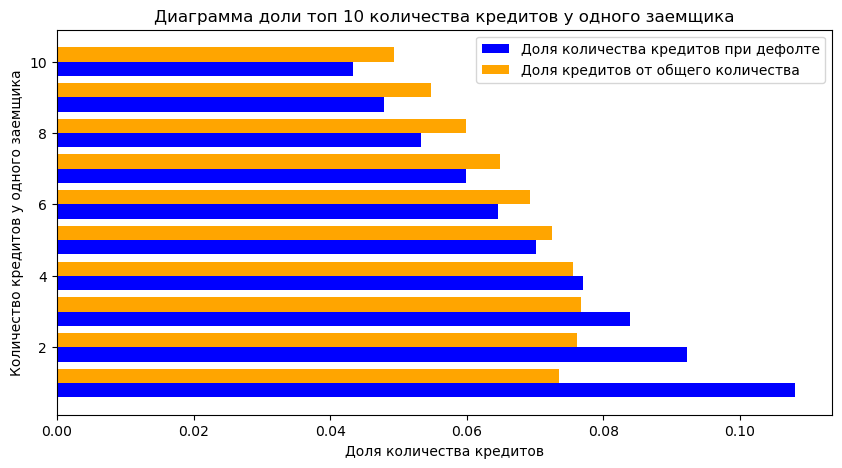

In [8]:
data = pd.merge(df_flag['rn'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['rn'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)
plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма доли топ 10 количества кредитов у одного заемщика')
plt.xlabel('Доля количества кредитов')
plt.ylabel('Количество кредитов у одного заемщика')
plt.legend(['Доля количества кредитов при дефолте', 'Доля кредитов от общего количества'])
plt.show()

Как видно из диаграммы в дефолт чаще выходят заемщики с количеством кредитов до 4-х включительно. Заемщики с количеством кредитов более 4-х являются более благонадежными. При этом, наиболее заметна разница выхода в дефолт при 1-м кредите, таким образом, в большинстве случаев заемщик переходит в категорию неблагонадежных с первого кредитного договора.

#### **2.2.2. Доля дефолтов от срока имеющейся просроченной задолженности**

Посмотрим на зависимость количества дефолтов от срока имеющейся просроченной задолженности по последнему кредиту заемщика.

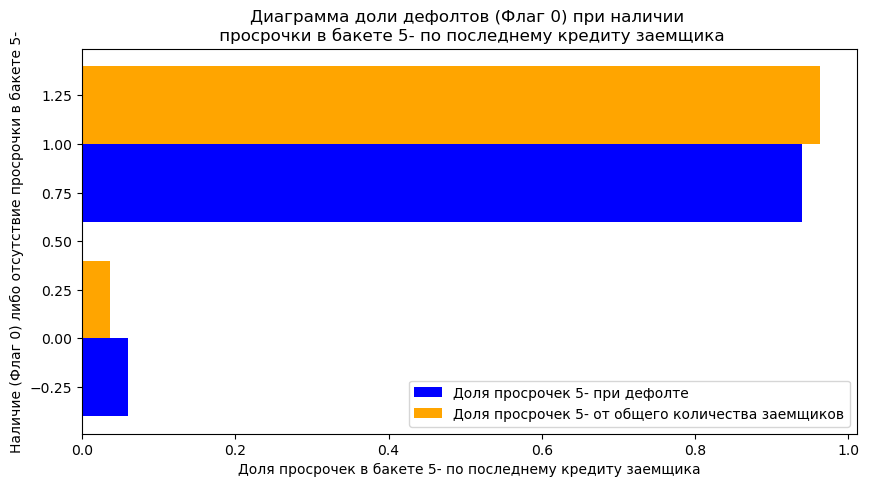

In [10]:
data = pd.merge(df_flag['last_is_zero_loans5'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_is_zero_loans5'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма доли дефолтов (Флаг 0) при наличии \n просрочки в бакете 5- по последнему кредиту заемщика')
plt.xlabel('Доля просрочек в бакете 5- по последнему кредиту заемщика')
plt.ylabel('Наличие (Флаг 0) либо отсутствие просрочки в бакете 5-')
plt.legend(['Доля просрочек 5- при дефолте', 'Доля просрочек 5- от общего количества заемщиков'])
plt.show()

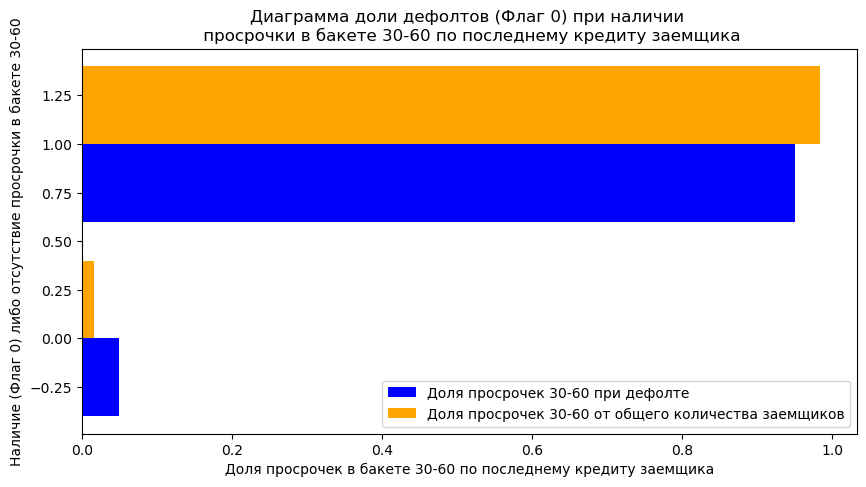

In [19]:
data = pd.merge(df_flag['last_is_zero_loans3060'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_is_zero_loans3060'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма доли дефолтов (Флаг 0) при наличии \n просрочки в бакете 30-60 по последнему кредиту заемщика')
plt.xlabel('Доля просрочек в бакете 30-60 по последнему кредиту заемщика')
plt.ylabel('Наличие (Флаг 0) либо отсутствие просрочки в бакете 30-60')
plt.legend(['Доля просрочек 30-60 при дефолте', 'Доля просрочек 30-60 от общего количества заемщиков'])
plt.show()

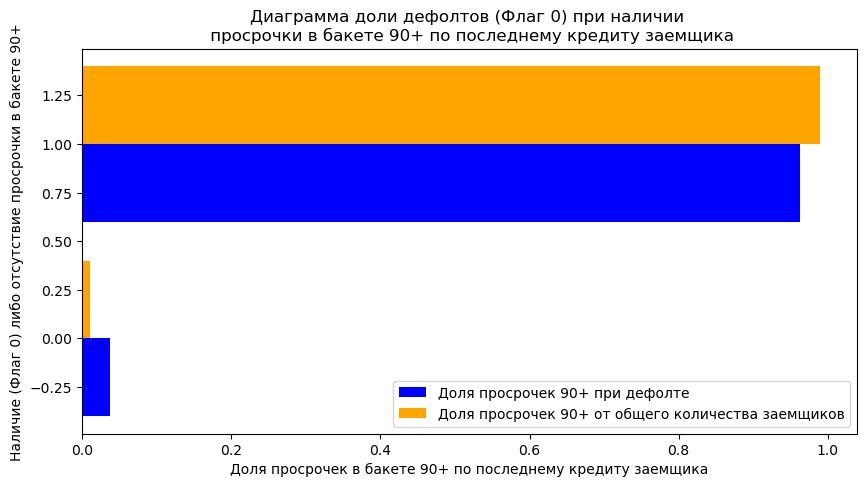

In [21]:
data = pd.merge(df_flag['last_is_zero_loans90'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_is_zero_loans90'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма доли дефолтов (Флаг 0) при наличии \n просрочки в бакете 90+ по последнему кредиту заемщика')
plt.xlabel('Доля просрочек в бакете 90+ по последнему кредиту заемщика')
plt.ylabel('Наличие (Флаг 0) либо отсутствие просрочки в бакете 90+')
plt.legend(['Доля просрочек 90+ при дефолте', 'Доля просрочек 90+ от общего количества заемщиков'])
plt.show()

Как и ожидалось, по данным из последних трех диаграмм, доля дефолтов растет от количества дней просрочки (Флаг - 0).

#### **2.2.3. Зависимость дефолтов от типа кредита у заемщика**

Посмотрим зависимость дефолта от самых популярных типов кредитов у заемщика.

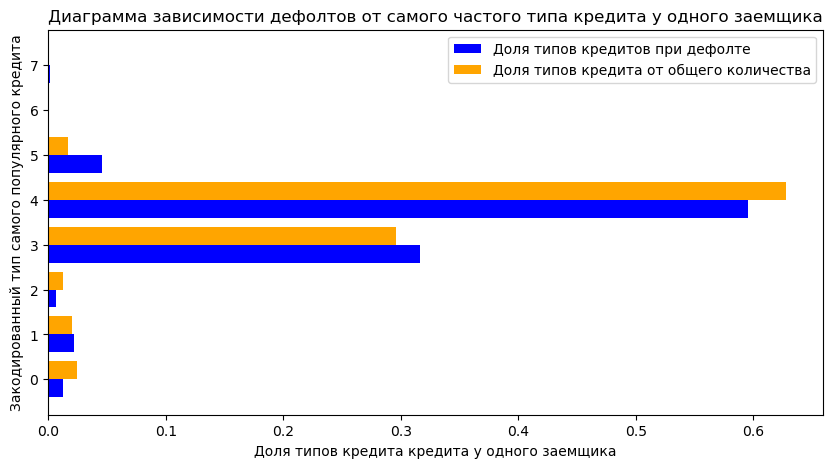

In [23]:
data = pd.merge(df_flag['credit_type'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['credit_type'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от самого частого типа кредита у одного заемщика')
plt.xlabel('Доля типов кредита кредита у одного заемщика')
plt.ylabel('Закодированный тип самого популярного кредита')
plt.legend(['Доля типов кредитов при дефолте', 'Доля типов кредита от общего количества'])
plt.show()

Также выведем зависимость дефолта от последнего типа кредита у заемщика.

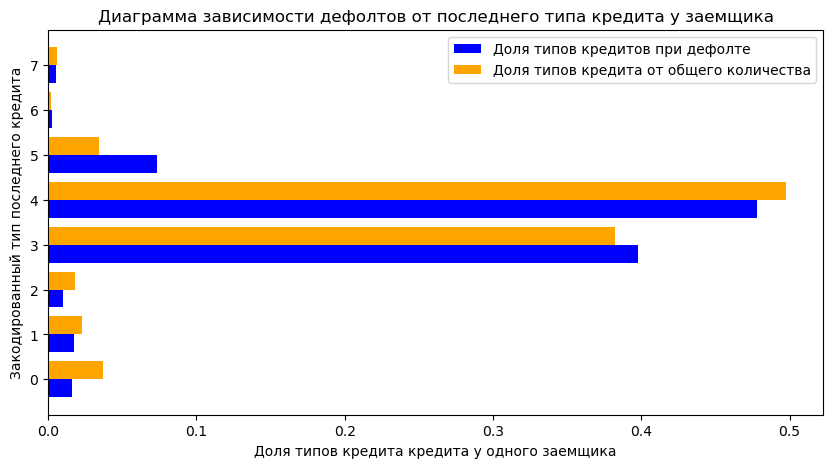

In [25]:
data = pd.merge(df_flag['last_credit_type'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_credit_type'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от последнего типа кредита у заемщика')
plt.xlabel('Доля типов кредита кредита у одного заемщика')
plt.ylabel('Закодированный тип последнего кредита')
plt.legend(['Доля типов кредитов при дефолте', 'Доля типов кредита от общего количества'])
plt.show()

В целом зависимости на последних двух диаграммах похожи, есть отличие в типе кредита 1, по которому дефолты случаются чаще если данный тип кредита наиболее часто встречается у заемщика. Если отметить три наиболее частых типа кредита, то при 4-ом типе кредита заемщики более склонны к добросовестному выполнению своих обязательств. А при 3-ем и 5-ом типе кредитов заемщики чаще допускают дефолт.

#### **2.2.4. Зависимость дефолтов от статуса кредита у заемщика**

Посмотрим зависимость дефолта от самых популярных статусов кредитов у заемщика.

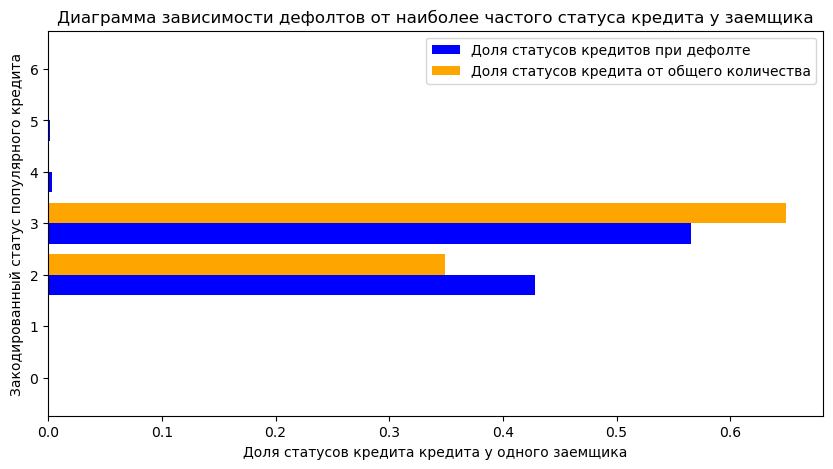

In [27]:
data = pd.merge(df_flag['credit_status'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['credit_status'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от наиболее частого статуса кредита у заемщика')
plt.xlabel('Доля статусов кредита кредита у одного заемщика')
plt.ylabel('Закодированный статус популярного кредита')
plt.legend(['Доля статусов кредитов при дефолте', 'Доля статусов кредита от общего количества'])
plt.show()

Также выведем зависимость дефолта от последнего статуса кредита у заемщика.

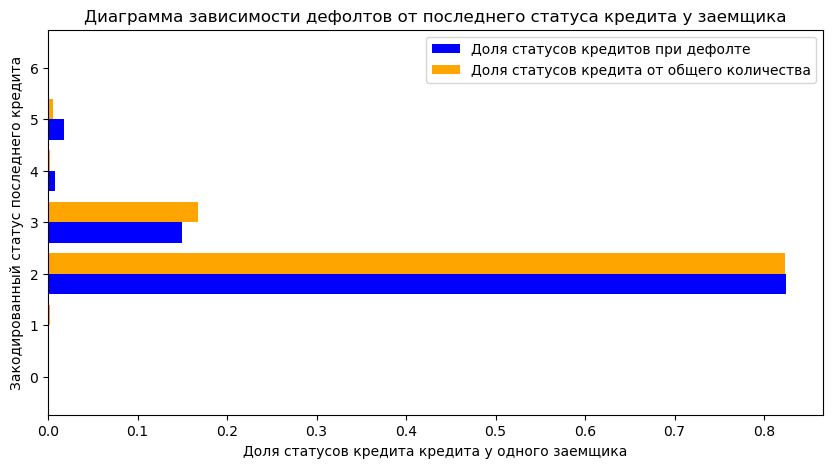

In [29]:
data = pd.merge(df_flag['last_credit_status'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_credit_status'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от последнего статуса кредита у заемщика')
plt.xlabel('Доля статусов кредита кредита у одного заемщика')
plt.ylabel('Закодированный статус последнего кредита')
plt.legend(['Доля статусов кредитов при дефолте', 'Доля статусов кредита от общего количества'])
plt.show()

Как видно из диаграмм 2-й статус кредита сильно превосходит остальные именно по последнему кредиту. С учетом того, что последние кредиты в большинстве своем могут являться действующими, возможно второй статус относится к действующему кредиту. При этом по последним статусам доля дефолтов почти совпадает с общим количеством информации по заемщикам.

#### **2.2.5. Зависимость дефолтов от статусов ежемесячных платежей**

Выведем зависимости дефолтов от статусов ежемесячных платежей на 1-й, 6-й, 12-й и 23-й месяцы по последним кредитам.

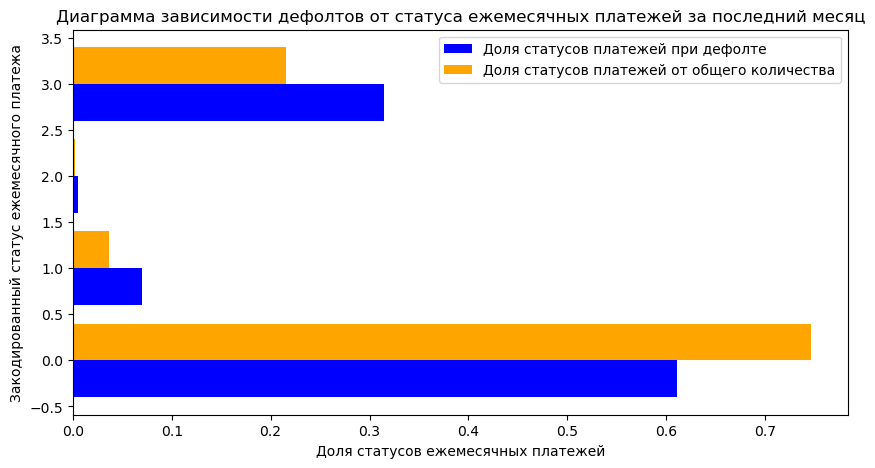

In [31]:
data = pd.merge(df_flag['last_paym_status_1'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_paym_status_1'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от статуса ежемесячных платежей за последний месяц')
plt.xlabel('Доля статусов ежемесячных платежей')
plt.ylabel('Закодированный статус ежемесячного платежа')
plt.legend(['Доля статусов платежей при дефолте', 'Доля статусов платежей от общего количества'])
plt.show()

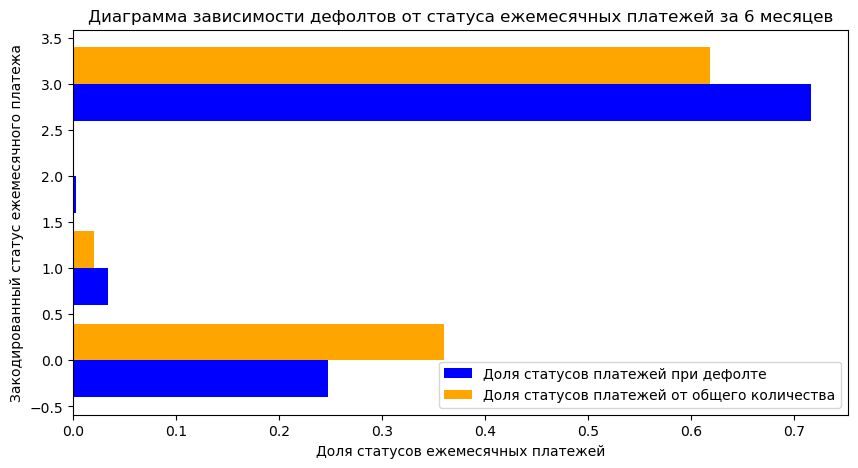

In [33]:
data = pd.merge(df_flag['last_paym_status_6'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_paym_status_6'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от статуса ежемесячных платежей за 6 месяцев')
plt.xlabel('Доля статусов ежемесячных платежей')
plt.ylabel('Закодированный статус ежемесячного платежа')
plt.legend(['Доля статусов платежей при дефолте', 'Доля статусов платежей от общего количества'])
plt.show()

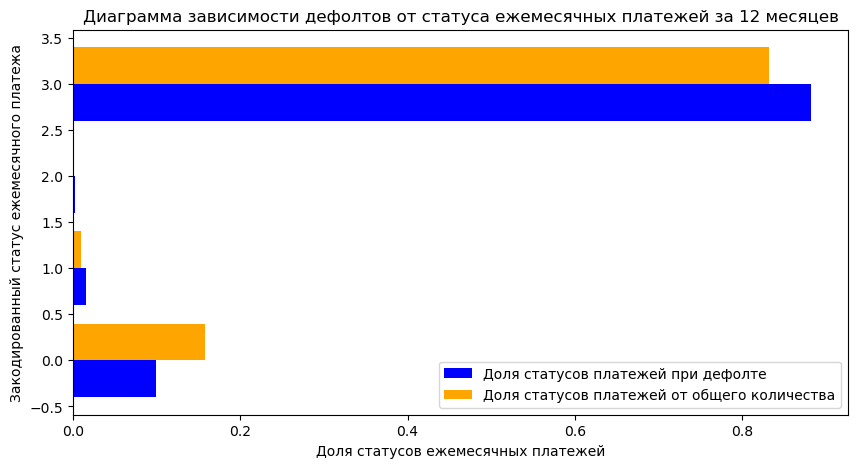

In [35]:
data = pd.merge(df_flag['last_paym_status_12'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_paym_status_12'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от статуса ежемесячных платежей за 12 месяцев')
plt.xlabel('Доля статусов ежемесячных платежей')
plt.ylabel('Закодированный статус ежемесячного платежа')
plt.legend(['Доля статусов платежей при дефолте', 'Доля статусов платежей от общего количества'])
plt.show()

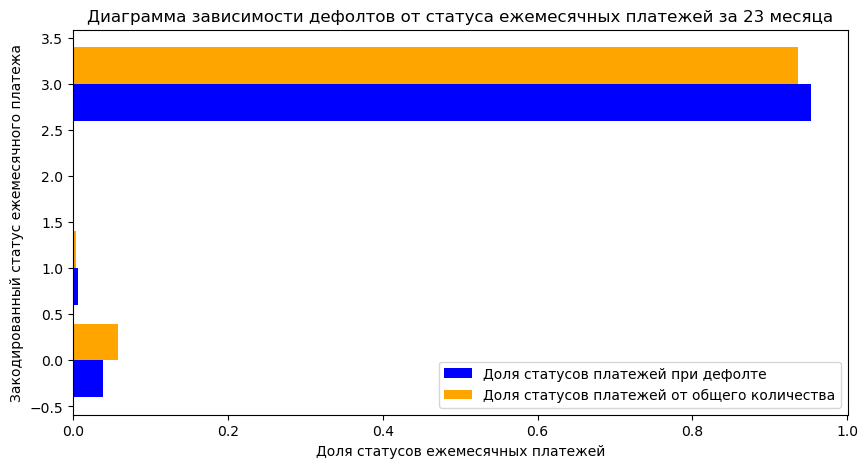

In [37]:
data = pd.merge(df_flag['last_paym_status_23'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_paym_status_23'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от статуса ежемесячных платежей за 23 месяца')
plt.xlabel('Доля статусов ежемесячных платежей')
plt.ylabel('Закодированный статус ежемесячного платежа')
plt.legend(['Доля статусов платежей при дефолте', 'Доля статусов платежей от общего количества'])
plt.show()

Как видно из 4-х диаграм основные закодированные статусы платежей: 0 и 3. Исходя из личного опыта основные статусы платежей - это "оплачено" и "просрочка". Из диаграмм видно, что с уведичением количества периодов растет доля платежей со статусом 3 и уменьшается доля платежей со статусом 0, при этом, по платежам в статусе 3 больше доля платежей у заемщиков допустивших дефолт по обязательствам.

#### **2.2.6. Зависимость дефолтов от кредитного лимита**

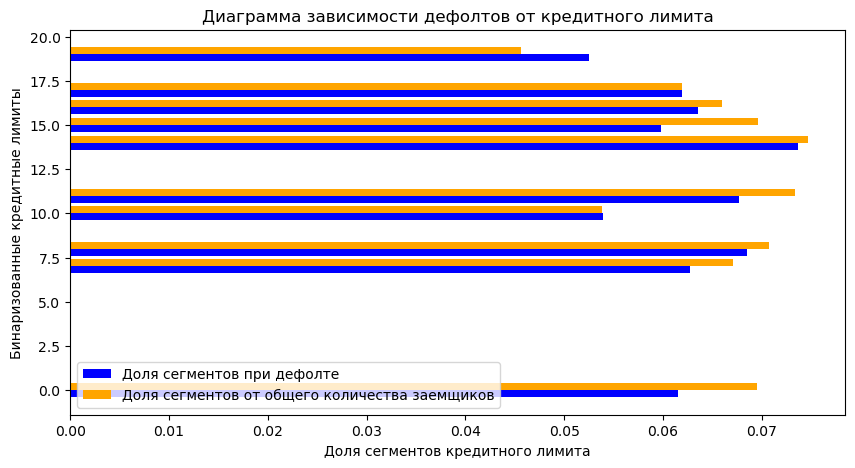

In [39]:
data = pd.merge(df_flag['credit_limit'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['credit_limit'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от кредитного лимита')
plt.xlabel('Доля сегментов кредитного лимита')
plt.ylabel('Бинаризованные кредитные лимиты')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

В 19-м сегменте доля дефолтов превосходит долю данного сегмента от общего количества заемщиков. Таким образом, размер кредитного лимита, соответствующий данному сегменту, чаще сопровождается дефолтом заемщика. 

#### **2.2.7. Зависимость дефолтов от максимальной просроченной задолженности**

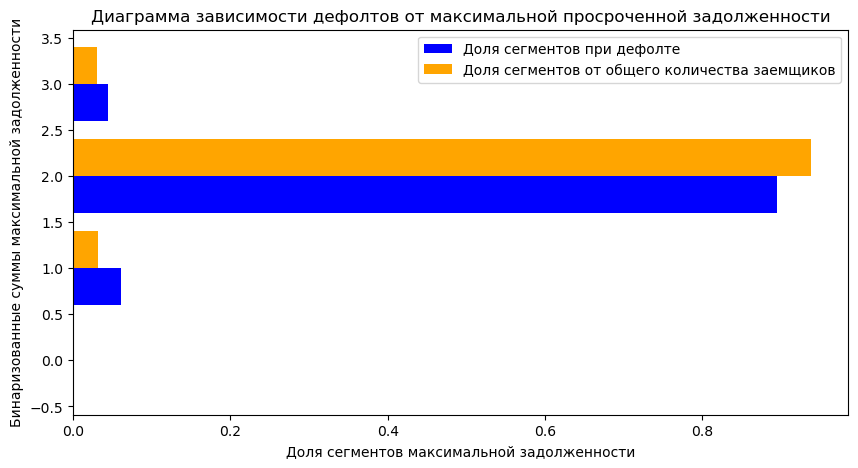

In [41]:
data = pd.merge(df_flag['max_overdue_sum'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['max_overdue_sum'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от максимальной просроченной задолженности')
plt.xlabel('Доля сегментов максимальной задолженности')
plt.ylabel('Бинаризованные суммы максимальной задолженности')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

Как видно из диаграммы, при 1-ом и 3-м сегменте максимальной задолженности, доля дефолтов заемщика выше, чем добросовестных плательщиков.

#### **2.2.8. Зависимость дефолтов от полной стоимости кредитов**

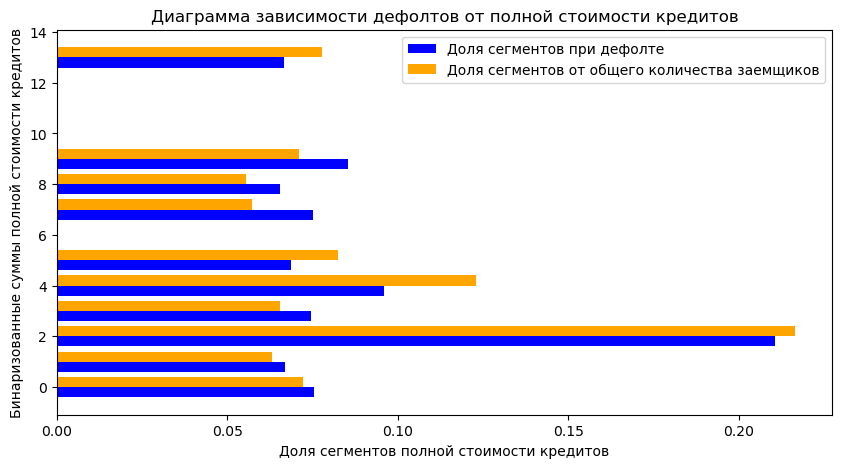

In [43]:
data = pd.merge(df_flag['credit_cost_rate'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['credit_cost_rate'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от полной стоимости кредитов')
plt.xlabel('Доля сегментов полной стоимости кредитов')
plt.ylabel('Бинаризованные суммы полной стоимости кредитов')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

Как видно из диаграммы, заемщики имеющие кредит с полной стоимостью из 0, 1, 3, 7, 8 и 9 сегментов, наиболее часто допускают дефолт по своим обязательствам.

#### **2.2.9. Зависимость дефолтов от отношения оставшейся невыплаченной суммы кредита к кредитному лимиту**

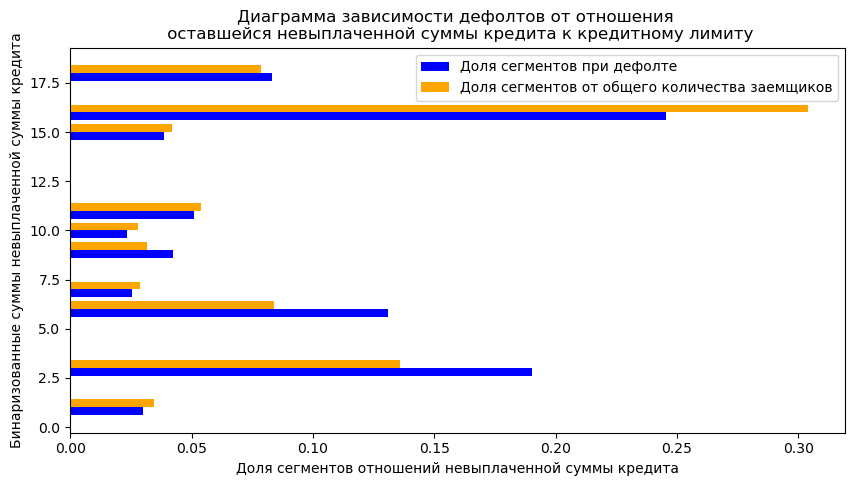

In [45]:
data = pd.merge(df_flag['pre_util'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['pre_util'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от отношения \n оставшейся невыплаченной суммы кредита к кредитному лимиту')
plt.xlabel('Доля сегментов отношений невыплаченной суммы кредита')
plt.ylabel('Бинаризованные суммы невыплаченной суммы кредита')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

Из диаграммы выидно, что наиболее неблагонадежные заемщики имеют отношение оставшейся невыплаченной суммы кредита к кредитному лимиту в 3-м и 6-м сегментах. При этом наиболее благонадежные заемщики имеют отношение оставшейся невыплаченной суммы кредита к кредитному лимиту в 16-м сегменте.

#### **2.2.10. Зависимость дефолтов от отношения просроченной задолженности к кредитному лимиту**

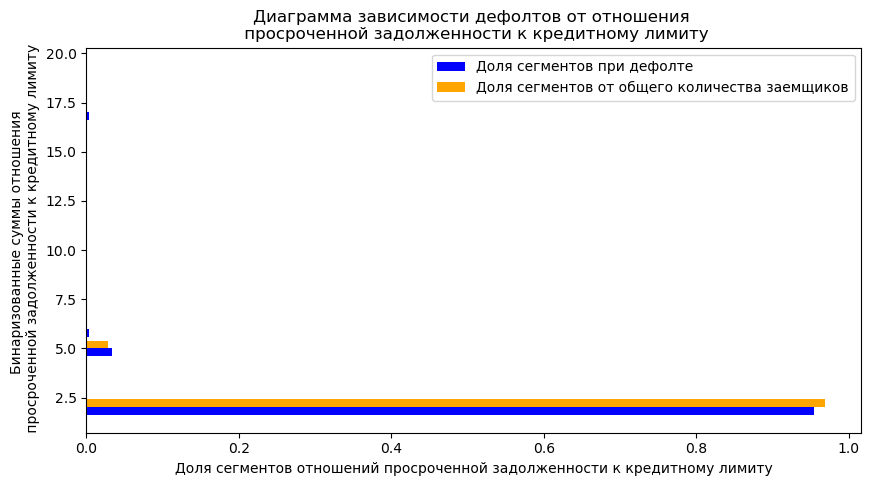

In [47]:
data = pd.merge(df_flag['pre_over2limit'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['pre_over2limit'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от отношения \n просроченной задолженности к кредитному лимиту')
plt.xlabel('Доля сегментов отношений просроченной задолженности к кредитному лимиту')
plt.ylabel('Бинаризованные суммы отношения \n просроченной задолженности к кредитному лимиту')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

Из диаграммы видно, что в основном отношение просроченной задолженности к кредитному лимиту попало во 2-й сегмент. При этом в 5-м сегменте доля дефолтов у заемщиков выше, чем общая доля заемщиков по данному сегменту.

#### **2.2.11. Зависимость дефолтов от отношения максимальной просроченной задолженности к кредитному лимиту**

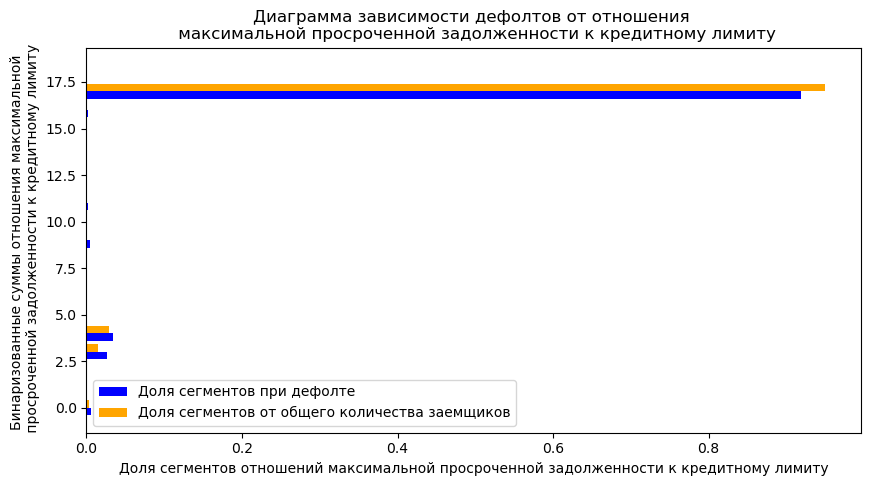

In [49]:
data = pd.merge(df_flag['pre_maxover2limit'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['pre_maxover2limit'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от отношения \n максимальной просроченной задолженности к кредитному лимиту')
plt.xlabel('Доля сегментов отношений максимальной просроченной задолженности к кредитному лимиту')
plt.ylabel('Бинаризованные суммы отношения максимальной \n просроченной задолженности к кредитному лимиту')
plt.legend(['Доля сегментов при дефолте', 'Доля сегментов от общего количества заемщиков'])
plt.show()

Из диаграммы видно, что в основном отношение максимальной просроченной задолженности к кредитному лимиту попало во 17-й сегмент. При этом в 0-м, 3-м, 4-м и 9-м сегменте доля дефолтов у заемщиков выше, чем общая доля заемщиков по данному сегменту.

#### **2.2.12. Зависимость дефолтов от типа отношения к кредиту**

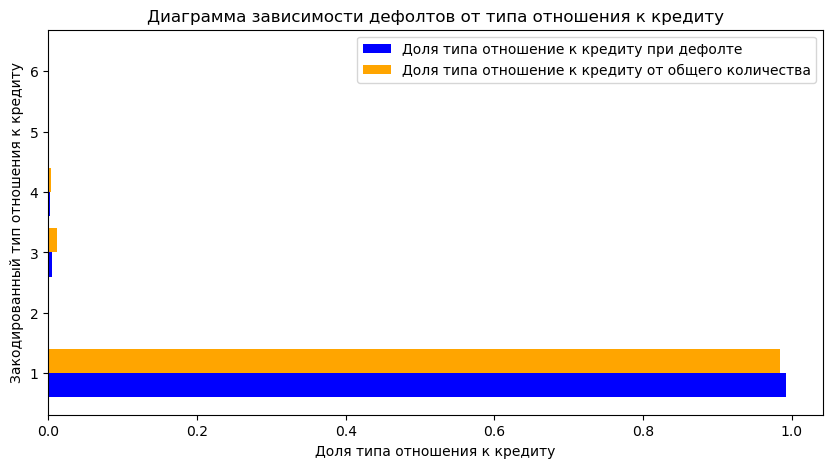

In [51]:
data = pd.merge(df_flag['last_holder_type'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_holder_type'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от типа отношения к кредиту')
plt.xlabel('Доля типа отношения к кредиту')
plt.ylabel('Закодированный тип отношения к кредиту')
plt.legend(['Доля типа отношение к кредиту при дефолте', 'Доля типа отношение к кредиту от общего количества'])
plt.show()

Из диаграммы видно, что в основном отношение к кредиту находятся в первом сегменте. Исходя из личного опыта в основном заемщик является стороной кредитных обязательств, поручители и тп. гораздо реже участвуют в кредитных отношениях. При этом, как раз заемщики чаще допускают дефолт по своим обязательствам перед кредитором, чем другие участники кредитных отношений.

#### **2.2.13. Зависимость дефолтов от валюты кредита**

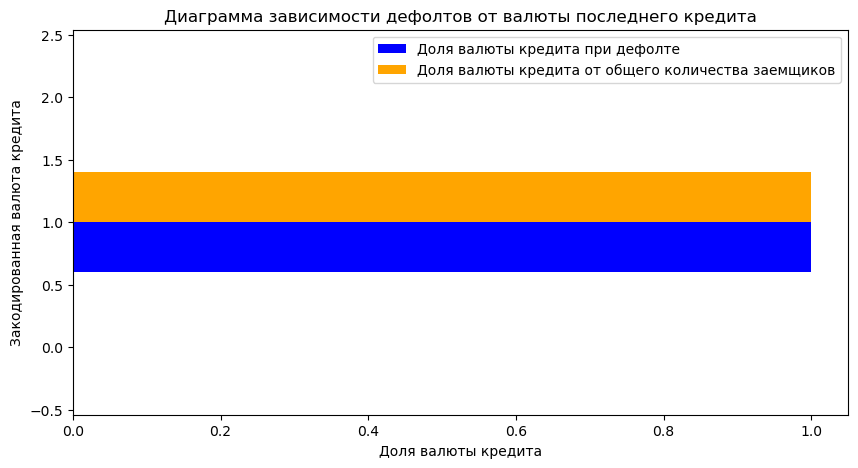

In [53]:
data = pd.merge(df_flag['last_account_cur'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['last_account_cur'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от валюты последнего кредита')
plt.xlabel('Доля валюты кредита')
plt.ylabel('Закодированная валюта кредита')
plt.legend(['Доля валюты кредита при дефолте', 'Доля валюты кредита от общего количества заемщиков'])
plt.show()

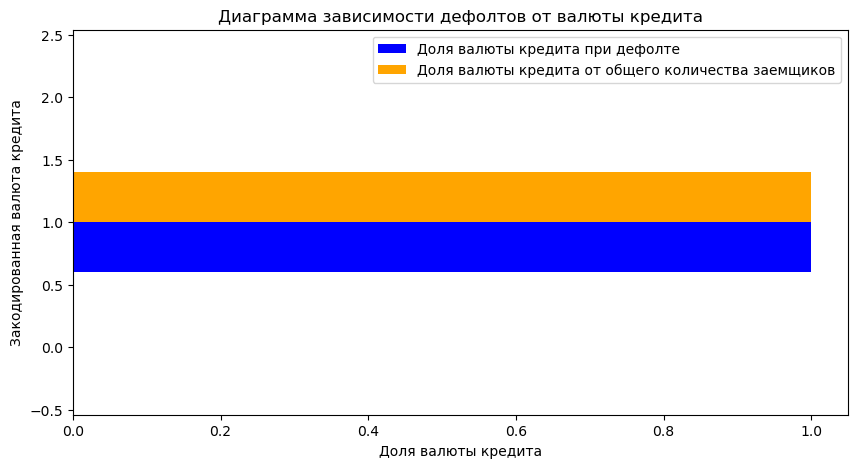

In [55]:
data = pd.merge(df_flag['account_cur'].value_counts().iloc[:10] / df_flag.shape[0], 
                df['account_cur'].value_counts() / df.shape[0], 
                how='left', left_index=True, right_index=True)

plt.figure(figsize=(10, 5))
plt.barh(data.index-0.2, data.count_x, 0.4, color='blue')
plt.barh(data.index+0.2, data.count_y, 0.4, color='orange')
plt.title('Диаграмма зависимости дефолтов от валюты кредита')
plt.xlabel('Доля валюты кредита')
plt.ylabel('Закодированная валюта кредита')
plt.legend(['Доля валюты кредита при дефолте', 'Доля валюты кредита от общего количества заемщиков'])
plt.show()

Из диаграмм зависимости кредита от типа валюты видно, что все кредиты относятся к одному типу валюты. С учетом того, что фичи last_account_cur и account_cur не дифференцированы по валюте, данные фичи можно не включать в датасет.

## **3. Feature engineering**

### **3.1. Создание новых переменных**

Попробовал создать переменную sum_loans, отражающую наличие либо отсутствие просрочек свыше 30 дней. Как показало последующее моделирование данная переменная не оказывала влияния на качество метрики.

In [ ]:
# df['sum_loans'] = df['rn'] * 3 - (df['count_is_zero_loans3060'] + df['count_is_zero_loans6090'] + df['count_is_zero_loans90'])
# df['sum_loans'] = df['sum_loans'].apply(lambda x: x if x == 0 else 1)
# df['sum_loans'].value_counts()

С учетом описания данных, переменная id была использована для моделирования предсказаний дефолтов, т.к. номер id отражал время обращения заемщика за кредитом. Переменная id была прологарифмирована, т.к. на мой взгляд, достаточно недавние обращения заемщика оказывают более весомый вклад в модель предсказаний и данный вклад уменьшается с нарастающей скоростью при id стремящемся к 0, такую зависимость хорошо описывает логарифмическая функция. Как показало дальнейшее моделирование, данная переменная улучшает качество метрики.

In [62]:
df['log_id'] = df['id'].apply(lambda x: 0 if x == 0 else np.log(x))
df.drop('id', axis=1, inplace=True)

Были созданы 9 новых переменных, которые отражают каличество просрочек у заемщика по всем кредитам в разрезе бакетов, деленные на общее количество кредитов. Как показало дальнейшее моделирование, данные переменные также улучшают качество метрики.

In [66]:
for col in df.columns.to_list()[1:9]:
    df[f'frac_{col.split("_")[-1]}'] = (df['rn'] - df[col]) / df['rn']
    df.drop(col, axis=1, inplace=True)

### **3.2. Преобразование категориальных переменных**

Преобразуем категориальные переменные. В нашем случае к категориальным переменным можно отнести все бинаризованные и закодированные данные. Но с учетом существенного размера датасета и недостаточностью ресурсов локального компьютета путем перебора были отобраны некоторые переменные, категоризация которых вносит наибольший вклад в качество метрики.

In [69]:
columns_to_encode = [
    'credit_limit',
    'next_pay_summ',
    'loans_outstanding',
    'total_overdue',
    'max_overdue_sum',
    'credit_cost_rate',
    'credit_status',
    # 'account_cur', 
    'credit_type',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit',
]

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[columns_to_encode])

OneHotEncoder(sparse_output=False)

In [70]:
df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])

C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\547530732.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])
C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\547530732.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])
C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\547530732.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

In [72]:
df.drop(columns_to_encode, axis=1, inplace=True)
df.head()

,rn,count_pclose_flag,count_fclose_flag,account_cur,paym_status_0,paym_status_1,paym_status_2,paym_status_3,paym_status_4,paym_status_5,...,pre_maxover2limit_10,pre_maxover2limit_11,pre_maxover2limit_12,pre_maxover2limit_13,pre_maxover2limit_14,pre_maxover2limit_15,pre_maxover2limit_16,pre_maxover2limit_17,pre_maxover2limit_18,pre_maxover2limit_19
0,10,1,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14,1,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,2,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,15,5,6,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,1,1,3,3,3,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### **3.3. Стандартизация числовых переменных**

В данной работе стандартизацию переменных не проводил, т.к. у нас большинство переменных носит категориальных характер, а имеющиеся числовые переменные имеют незначительный разброс (даже если возьмем максимальное id равное 3 млн., то натуральный логарифм данного числа будет равен 14,9). Кроме этого, как показало дальнейшее моделирование, преимущественно будем использовать модели, основанные на ансаблях решающих деревьев, для которых стандартизация не является обязательной процедурой.

In [ ]:
# columns_to_scaler = [
    
# ]
# std = StandardScaler()
# df[columns_to_scaler] = std.fit_transform(df[columns_to_scaler])
# df.head()

## **4. Modeling**

Разобьем наши данные на обучающую и тестовую выборки в соотношении 70 к 30, что соответствует условию поставленной задачи. Кроме этого, при разбиении используем параметр stratify=y для сохранения соотношения классов в обучающей и тестовой выборках.

In [80]:
X = df.drop('flag', axis=1)
y = df.flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

### **4.1. BaseLine**

С учетом того, что датасет несбалансирован, будем использовать для для балансировки веса классов.

#### **4.1.1. BaseLine LogisticRegression**

In [83]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr_train = lr.predict_proba(X_train)[:, 1]
pred_lr = lr.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC LogisticRegression на тренировочной выборке: {roc_auc_score(y_train, pred_lr_train)}')
print(f'Метрика ROC-AUC LogisticRegression на тестовой выборке: {roc_auc_score(y_test, pred_lr)}')

C:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрика ROC-AUC LogisticRegression на тренировочной выборке: 0.7171413187939129
Метрика ROC-AUC LogisticRegression на тестовой выборке: 0.7150614686741903


#### **4.1.2. BaseLine RandomForestClassifier**

Для исключения переобучения модели случайного леса введем максимальную глубину деревьев в моделе.

In [90]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=7)
rf.fit(X_train, y_train)
pred_rf_train = rf.predict_proba(X_train)[:, 1]
pred_rf = rf.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC RandomForestClassifier на тренировочной выборке: {roc_auc_score(y_train, pred_rf_train)}')
print(f'Метрика ROC-AUC RandomForestClassifier на тестовой выборке: {roc_auc_score(y_test, pred_rf)}')

Метрика ROC-AUC RandomForestClassifier на тренировочной выборке: 0.7027844079331255
Метрика ROC-AUC RandomForestClassifier на тестовой выборке: 0.6985542372099861


#### **4.1.3. BaseLine MLP**

Построим нейросеть из двух слоев с небольшим количеством нейронов.

In [103]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 20))
mlp.fit(X_train, y_train)
pred_mlp_train = mlp.predict_proba(X_train)[:, 1]
pred_mlp = mlp.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC MLP на тренировочной выборке: {roc_auc_score(y_train, pred_mlp_train)}')
print(f'Метрика ROC-AUC MLP на тестовой выборке: {roc_auc_score(y_test, pred_mlp)}')

Метрика ROC-AUC MLP на тренировочной выборке: 0.7384188141852697
Метрика ROC-AUC MLP на тестовой выборке: 0.732385531865261


#### **4.1.4. BaseLine HistGradientBoostingClassifier**

Попробуем использовать "быструю" модель градиентного бустинга из библиотеки sklearn.

In [104]:
hgb = HistGradientBoostingClassifier(class_weight='balanced')
hgb.fit(X_train, y_train)
pred_hgb_train = hgb.predict_proba(X_train)[:, 1]
pred_hgb = hgb.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC HistGradientBoosting на тренировочной выборке: {roc_auc_score(y_train, pred_hgb_train)}')
print(f'Метрика ROC-AUC HistGradientBoosting на тестовой выборке: {roc_auc_score(y_test, pred_hgb)}')

Метрика ROC-AUC HistGradientBoosting на тренировочной выборке: 0.7471089488947609
Метрика ROC-AUC HistGradientBoosting на тестовой выборке: 0.7367245749044558


#### **4.1.5. BaseLine LightGBM**

Также попробуем использовать "быструю" модель градиентного бустинга LightGBM. Как показали дальнейшие экперименты скорость данной модели позволила на нашем большом датасете провести большое количество экспериментом за достаточно приемлемое время.

In [105]:
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm = LGBMClassifier(class_weight=class_weights)
lgbm.fit(X_train, y_train)
pred_lgbm_train = lgbm.predict_proba(X_train)[:, 1]
pred_lgbm = lgbm.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC LGBMClassifier на тренировочной выборке: {roc_auc_score(y_train, pred_lgbm_train)}')
print(f'Метрика ROC-AUC LGBMClassifier на тестовой выборке: {roc_auc_score(y_test, pred_lgbm)}')

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.322719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
Метрика ROC-AUC LGBMClassifier на тренировочной выборке: 0.746577148420217
Метрика ROC-AUC LGBMClassifier на тестовой выборке: 0.7375012049659946


#### **4.1.6. Выводы по BaseLine**

Как видно из параметров метрики ROC-AUC на тренировочной и тестовой выборках переобучения не было, при этом модели уже показывали достаточно не плохой результат, что говорит о приемлимых данных в нашем датасете. При этом особенно хорошо себя показывают модели градиентного бустинга, кроме этого, они обучаются в разы быстрее прочих моделей.

### **4.2. Model tuning**

**С учетом того, что датасет большой и обучение занимает значительное время, параметры моделей перебирались вручную без использования поиска по сетке GridSearchCV. Все результаты полученных метрик при переборе параметров моделей не привожу, так как из-за "тяжелого" датасета приходилось перегружать ядро для очистки памяти. Приведу только описание перебираемых параметров.**

#### **4.2.1. LogisticRegression**

При подборе параметров Логистической регрессии перебирались: алгоритмы оптимизации lbfgs, liblinear, newton-cg, saga; регуляризаторы l1, l2, elasticnet; количество итераций до 300; коэффициент С (код для подбора коэффиента ниже). При переборе данных параметров метрика ROC-AUC нашей модели не превышала 72%.

In [ ]:
max_pred_lr_train = 0.
max_pred_lr = 0.
max_reg = 0.
for reg in np.arange(0.05, 10.06, 0.1):
    lr = LogisticRegression(class_weight='balanced', C=reg, n_jobs=-1)
    lr.fit(X_train, y_train)
    pred_lr_train = lr.predict_proba(X_train)[:, 1]
    pred_lr = lr.predict_proba(X_test)[:, 1]
    print(f'Метрика ROC-AUC LogisticRegression на тренировочной выборке при С = {reg}: {roc_auc_score(y_train, pred_lr_train)}')
    print(f'Метрика ROC-AUC LogisticRegression на тестовой выборке при С = {reg}: {roc_auc_score(y_test, pred_lr)}')
    if roc_auc_score(y_test, pred_lr) > max_pred_lr:
        max_pred_lr_train = roc_auc_score(y_train, pred_lr_train)
        max_pred_lr = roc_auc_score(y_test, pred_lr)
        max_reg = reg
print(f'Максимальная метрика ROC-AUC LogisticRegression на тренировочной выборке при С = {max_reg}: {max_pred_lr_train}')
print(f'Максимальная метрика ROC-AUC LogisticRegression на тестовой выборке при С = {max_reg}: {max_pred_lr}')
        

#### **4.2.2. RandomForestClassifier**

При подборе параметров Случайного леса перебирались: количество деревьев до 500; максимальная глубина дерева от 3 до 15; количество фичей для каждого дерева в ансабле. При переборе данных параметров метрика ROC-AUC нашей модели не превышала 71%. Кроме этого, скорость обочения занимала значительный промежуток времени.

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=7)

#### **4.2.3. MLP**

В моделе персептрона перебирались: количество слоев и нейронов в них, количество слоев доводил до 3-х с 200 нейронов в каждом скрытом слое; менял функцию активации identity, logistic, tanh, relu; менял алгоритмы оптимизации lbfgs, sgd, adam. Обучение нейросети особенно при трех скрытых слоях занимало очень много времени, при этом показатель метрики ROC-AUC не превышал 74%.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 20))

#### **4.2.4. Модели градиентного бустинга**

Обе модели градиентного бустинга показали наилучшые результаты метрики ROC-AUC, при этом обучение занимало немного времени, что позволило провести множество экспериментов с переменными и параметрами. С учетом того, что модель LightGBM имеет больше параметров для тонкой настройки, и ее метрика на BaseLine была немного выше модели HistGradientBoostingClassifier, то принял решение использовать и тюнинговать LightGBM.

При тюнинге модели LightGBM перебирались следующие параметры: количество деревьев в ансамбле от 300 до 5000; типы бустинга gbdt, dart, goss; количество листьев в дереве от 10 до 50; максимальная глубина деревьев в ансамбле от 3-х до 15-ти. Наилучший результат получился при количестве деревьев в ансамбле равном 500 и остальными параметрами по умолчанию.

In [136]:
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm = LGBMClassifier(class_weight=class_weights, n_estimators=500)
lgbm.fit(X_train, y_train)
pred_lgbm_train = lgbm.predict_proba(X_train)[:, 1]
pred_lgbm = lgbm.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC LGBMClassifier на тренировочной выборке: {roc_auc_score(y_train, pred_lgbm_train)}')
print(f'Метрика ROC-AUC LGBMClassifier на тестовой выборке: {roc_auc_score(y_test, pred_lgbm)}')

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.440543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
Метрика ROC-AUC LGBMClassifier на тренировочной выборке: 0.7712883663660763
Метрика ROC-AUC LGBMClassifier на тестовой выборке: 0.7424806899987049


Также проверим нашу модель по кросс-валидации

In [141]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
score = cross_val_score(lgbm, X, y, scoring=make_scorer(roc_auc_score, needs_proba=True), cv=skf)
print(f'ROC_AUC: {score} ROC_AUC_mean: {score.mean():.4f}, ROC_AUC_std: {score.std():.4f}')

[LightGBM] [Info] Number of positive: 85154, number of negative: 2314846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.636213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Info] Number of positive: 85154, number of negative: 2314846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 212
[LightGBM]

По результатам кросс-валидации усредненная метрика ROC-AUC получилась 74,4%, что недостаточно по уловиям нашей задачи. При этом, судя по стандартному отклонению значение метрики показывает достаточно стабильные результаты на разных фолдах.

#### **4.2.5. Add tuning LightGBM**

С учетом того, что в нашем датасете отсутствуют непрерывные числовые переменные (о чем писал на этапе EDA) и проверить датасет на наличие выбросов и аномалий нельзя, попробуем выделить объекты, которые наша модель предсказать не в состоянии (процент предикта дефолта высокий, но при этом значение целевой переменной равно 0 и наоборот).

Проведем селекцию наших объектов без предобработки, для этого заново загрузим датасет, построим модель, на предиктах отсеем некоторые объекты датасета, проведем предобрабоку и обучим модель

In [148]:
df = pd.read_csv('data/df_full.csv')

Создадим отдельный датафрейм для выделения объектов, которые наша модель предсказать не в состоянии для использования в разделе моделирования.

In [150]:
df_out = df[['id', 'flag']]
df_out.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [152]:
X = df.drop('flag', axis=1)
y = df.flag

class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm_premodeling = LGBMClassifier(class_weight=class_weights, n_estimators=500)
lgbm_premodeling.fit(X, y)
pred_lgbm_premodeling = lgbm_premodeling.predict_proba(X)[:, 1]
print(f'Метрика ROC-AUC LGBMClassifier для предмоделирования: {roc_auc_score(y, pred_lgbm_premodeling)}')

[LightGBM] [Info] Number of positive: 106442, number of negative: 2893558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 3000000, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Метрика ROC-AUC LGBMClassifier для предмоделирования: 0.7620929578193


In [154]:
df_out['proba_1'] = pred_lgbm_premodeling
df_out.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\561181712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['proba_1'] = pred_lgbm_premodeling


,id,flag,proba_1
0,0,0,0.159864
1,1,0,0.497977
2,2,0,0.737442
3,3,0,0.295689
4,4,0,0.445842


Удалим из нашего датасета все объекты у которых предсказание класса 1 выше 80% при целевой переменной равной 0, а также предсказание класса 0 ниже 10% при целевой переменной равной 1. Посмотрим на размерность.

In [157]:
num_id = ((df_out['proba_1'] > 0.8) & (df_out['flag'] == 0)) | ((df_out['proba_1'] < 0.1) & (df_out['flag'] == 1))
df = df[~df['id'].isin(df_out[num_id]['id'].unique())]

df.shape

(2934678, 101)

In [159]:
print(f'Оставшееся количество объектов от первоначального количества: {df.shape[0]/3000000}')

Оставшееся количество объектов от первоначального количества: 0.978226


Наш датасет сократился чуть более чем на 2%, что на мой взгляд приемлемо.

Проведем заново предобработки и обучим нашу модель.

In [164]:
df['log_id'] = df['id'].apply(lambda x: 0 if x == 0 else np.log(x))
df.drop('id', axis=1, inplace=True)
for col in df.columns.to_list()[1:9]:
    df[f'frac_{col.split("_")[-1]}'] = (df['rn'] - df[col]) / df['rn']
    df.drop(col, axis=1, inplace=True)

In [165]:
columns_to_encode = [
    'credit_limit',
    'next_pay_summ',
    'loans_outstanding',
    'total_overdue',
    'max_overdue_sum',
    'credit_cost_rate',
    'credit_status',
    # 'account_cur', 
    'credit_type',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit',
]

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[columns_to_encode])

OneHotEncoder(sparse_output=False)

In [166]:
df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])
df.drop(columns_to_encode, axis=1, inplace=True)
df.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\3359207565.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])
C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\3359207565.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.transform(df[columns_to_encode])
C:\Users\Alex\AppData\Local\Temp\ipykernel_14328\3359207565.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

,rn,count_pclose_flag,count_fclose_flag,account_cur,paym_status_0,paym_status_1,paym_status_2,paym_status_3,paym_status_4,paym_status_5,...,pre_maxover2limit_10,pre_maxover2limit_11,pre_maxover2limit_12,pre_maxover2limit_13,pre_maxover2limit_14,pre_maxover2limit_15,pre_maxover2limit_16,pre_maxover2limit_17,pre_maxover2limit_18,pre_maxover2limit_19
0,10,1,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,14,1,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,2,2,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,15,5,6,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,1,1,3,3,3,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [167]:
X = df.drop('flag', axis=1)
y = df.flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [168]:
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm = LGBMClassifier(class_weight=class_weights, n_estimators=500)
lgbm.fit(X_train, y_train)
pred_lgbm_train = lgbm.predict_proba(X_train)[:, 1]
pred_lgbm = lgbm.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC LGBMClassifier на тренировочной выборке: {roc_auc_score(y_train, pred_lgbm_train)}')
print(f'Метрика ROC-AUC LGBMClassifier на тестовой выборке: {roc_auc_score(y_test, pred_lgbm)}')

[LightGBM] [Info] Number of positive: 74444, number of negative: 1979830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.341977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2157
[LightGBM] [Info] Number of data points in the train set: 2054274, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000004
[LightGBM] [Info] Start training from score -0.000004
Метрика ROC-AUC LGBMClassifier на тренировочной выборке: 0.7860181270260379
Метрика ROC-AUC LGBMClassifier на тестовой выборке: 0.759592110316685


Также проверим метрику ROC-AUC по кросс-валидации.

In [175]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
score = cross_val_score(lgbm, X, y, scoring=make_scorer(roc_auc_score, needs_proba=True), cv=skf)
print(f'ROC_AUC: {score} ROC_AUC_mean: {score.mean():.4f}, ROC_AUC_std: {score.std():.4f}')

[LightGBM] [Info] Number of positive: 85079, number of negative: 2262663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.565224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 2347742, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000002
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Info] Number of positive: 85079, number of negative: 2262663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.436107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 2347742, number of used features: 212
[LightGB

Метрика ROC_AUC при разделении на тренировочную и тестовую выборки, а также по кросс-валидации получилась более 75%, что требовалось по условию.

## **5. Pipeline**